<a href="https://colab.research.google.com/github/MasahiroAraki/MachineLearning3/blob/master/notebook/chap05.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -U scikit-learn --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 44.3 MB/s eta 0:00:00


# 第5章

Scikit learn の [GaussianNB](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html)（生成モデル）と [LogisticRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html)（識別モデル） で識別を行います。



## 例題 5.1

`NaiveBayes` 識別器を用いて，Iris データを識別せよ．

必要なライブラリ等を読み込みます。

In [1]:
# 5章で用いるライブラリ
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_breast_cancer, load_wine
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.model_selection import cross_val_score

In [2]:
# Jupyter notebook で出力を見やすくするための設定
%precision 3
np.set_printoptions(precision=3, suppress=True)
pd.set_option("display.precision", 3)
sns.set_theme()

Irisデータを読み込みます。クラスごとの分析をするので、seaborn から正解情報がひとつになった DataFrame を読み込みます。

In [3]:
df = sns.load_dataset("iris")
df

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,virginica
146,6.3,2.5,5.0,1.9,virginica
147,6.5,3.0,5.2,2.0,virginica
148,6.2,3.4,5.4,2.3,virginica


クラス毎の統計値を表示します。

In [4]:
df.groupby('species').mean()

,sepal_length,sepal_width,petal_length,petal_width
species,,,,
setosa,5.006,3.428,1.462,0.246
versicolor,5.936,2.770,4.260,1.326
virginica,6.588,2.974,5.552,2.026


In [5]:
df.groupby('species').var(ddof=0) # 標本分散

,sepal_length,sepal_width,petal_length,petal_width
species,,,,
setosa,0.122,0.141,0.030,0.011
versicolor,0.261,0.097,0.216,0.038
virginica,0.396,0.102,0.298,0.074


In [6]:
X = df.drop('species', axis=1)
y = df['species']

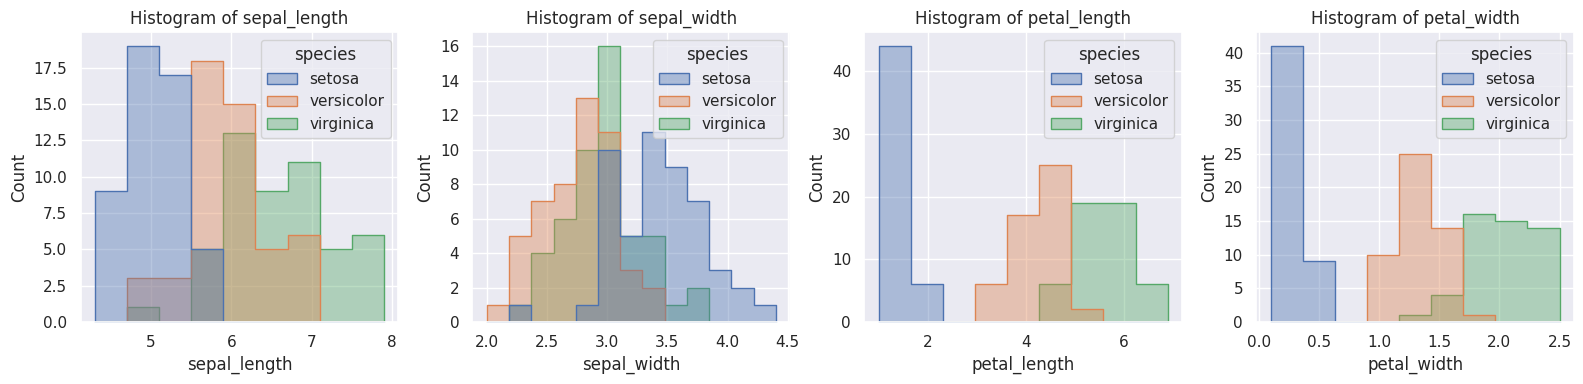

In [7]:
# サブプロットの作成
fig, axes = plt.subplots(1, len(X.columns), figsize=(16, 4))

# 各特徴ごとにクラスで色分けした透明なヒストグラムをプロット
for i, feature in enumerate(X.columns):
    sns.histplot(data=df, x=feature, hue='species', ax=axes[i], kde=False, element="step", alpha=0.4)
    axes[i].set_title(f'Histogram of {feature}')

# グラフの表示
plt.tight_layout()
plt.savefig('s5-1.svg', format='svg', bbox_inches='tight')
plt.show()

In [8]:
clf1 = GaussianNB()
clf1.fit(X, y)

,priors,None
,var_smoothing,1e-09


各クラスの正規分布の平均(theta)と分散(var)を表示します。

In [9]:
clf1.theta_

array([[5.006, 3.428, 1.462, 0.246],
       [5.936, 2.77 , 4.26 , 1.326],
       [6.588, 2.974, 5.552, 2.026]])

In [10]:
clf1.var_

array([[0.122, 0.141, 0.03 , 0.011],
       [0.261, 0.097, 0.216, 0.038],
       [0.396, 0.102, 0.298, 0.074]])

この結果は、たとえばクラス0(setosa; 先頭の50個)の特徴 sepal lengthを表す正規分布は平均5.006、分散0.122と最尤推定されたことを示しています。他の特徴、他のクラスについても読み込んだDataFrameを参照して、妥当な値になっていることを確認してください。

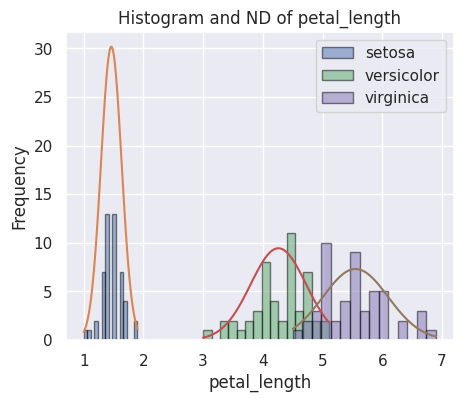

In [11]:
import scipy as sp

# 対象とする次元
feat_num = 2
feature = X.columns[feat_num] # petal_length

plt.figure(figsize=(5, 4))

for i, species in enumerate(df['species'].unique()):
    data = df[df['species'] == species][feature]
    # ヒストグラムのプロット
    counts, bins, _ = plt.hist(data, alpha=0.5, label=species, bins=15, edgecolor='black')
    # 正規分布の曲線のプロット
    mean = clf1.theta_[i, feat_num]
    std = np.sqrt(clf1.var_[i, feat_num])
    x = np.linspace(bins[0], bins[-1], 100)
    scale_factor = max(counts)  # ヒストグラムの最大高さにスケーリング
    plt.plot(x, sp.stats.norm.pdf(x, mean, std) * scale_factor)

plt.xlabel(feature)
plt.ylabel('Frequency')
plt.title('Histogram and ND of ' + feature)
plt.legend(loc='upper right')
plt.savefig('s5-2.svg', format='svg', bbox_inches='tight')
plt.show()

In [12]:
scores = cross_val_score(clf1, X, y, cv=10)
print(f"Accuracy: {scores.mean():.2f} (+/- {scores.std()*2:.2f})")

Accuracy: 0.95 (+/- 0.09)


## 例題5.2

LogisticRegression で Breast Cancer データを識別せよ

In [13]:
df = load_breast_cancer(as_frame=True)
X = df.data
y = df.target
X.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,17.99,10.38,122.80,1001.0,0.118,0.278,0.300,0.147,0.242,0.079,...,25.38,17.33,184.60,2019.0,0.162,0.666,0.712,0.265,0.460,0.119
1,20.57,17.77,132.90,1326.0,0.085,0.079,0.087,0.070,0.181,0.057,...,24.99,23.41,158.80,1956.0,0.124,0.187,0.242,0.186,0.275,0.089
2,19.69,21.25,130.00,1203.0,0.110,0.160,0.197,0.128,0.207,0.060,...,23.57,25.53,152.50,1709.0,0.144,0.424,0.450,0.243,0.361,0.088
3,11.42,20.38,77.58,386.1,0.142,0.284,0.241,0.105,0.260,0.097,...,14.91,26.50,98.87,567.7,0.210,0.866,0.687,0.258,0.664,0.173
4,20.29,14.34,135.10,1297.0,0.100,0.133,0.198,0.104,0.181,0.059,...,22.54,16.67,152.20,1575.0,0.137,0.205,0.400,0.163,0.236,0.077


In [14]:
y.head().to_list()

[0, 0, 0, 0, 0]

In [15]:
pipe = make_pipeline(StandardScaler(), LogisticRegression(max_iter=10000))
scores = cross_val_score(pipe, X, y, cv=10)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std()*2))

Accuracy: 0.98 (+/- 0.03)


In [16]:
pipe.fit(X, y)
model = pipe.named_steps['logisticregression']
print('g(x) =')
for (w, f) in zip(model.coef_[0], pipe.feature_names_in_):
    print(f"{w:8.3f} * {f}")
print(f"+ {model.intercept_[0]:6.3f}")

g(x) =
  -0.375 * mean radius
  -0.382 * mean texture
  -0.361 * mean perimeter
  -0.439 * mean area
  -0.167 * mean smoothness
   0.561 * mean compactness
  -0.855 * mean concavity
  -0.963 * mean concave points
   0.076 * mean symmetry
   0.328 * mean fractal dimension
  -1.289 * radius error
   0.265 * texture error
  -0.672 * perimeter error
  -0.999 * area error
  -0.280 * smoothness error
   0.744 * compactness error
   0.101 * concavity error
  -0.323 * concave points error
   0.295 * symmetry error
   0.682 * fractal dimension error
  -1.027 * worst radius
  -1.321 * worst texture
  -0.820 * worst perimeter
  -0.995 * worst area
  -0.666 * worst smoothness
   0.051 * worst compactness
  -0.880 * worst concavity
  -0.925 * worst concave points
  -0.889 * worst symmetry
  -0.487 * worst fractal dimension
+  0.221


## 例題 5.3

scikit-learnの `SGDClassifier` アルゴリズムを用いて，Wine データを識別する識別器を作成せよ．

In [17]:
wine = load_wine()
X = wine.data
y = wine.target

In [18]:
pipe = make_pipeline(StandardScaler(), SGDClassifier(loss='log_loss', random_state=5, max_iter=1000))
scores = cross_val_score(pipe, X, y, cv=10)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std()*2))

Accuracy: 0.98 (+/- 0.07)


# 演習問題


### 5-1

カテゴリ特徴と数値特徴の両方をもつ Weather.numeric データに対して，ナイーブベイズ識別器を作成し，['rainy', 80, 82, 'FALSE'] の識別結果と，その確率を示せ．

In [19]:
import numpy as np
import pandas as pd
from sklearn.datasets import fetch_openml
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.naive_bayes import GaussianNB
from sklearn.pipeline import make_pipeline

df = fetch_openml(data_id=42690)
X = df.data.drop('play', axis=1)
y = df.data['play']

categorical_features = ['outlook', 'windy']
numeric_features = ['temperature', 'humidity']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(), categorical_features)
    ])

pipe = make_pipeline(preprocessor, GaussianNB())
pipe.fit(X, y)

new_data = pd.DataFrame([['rainy', 80, 82, 'FALSE']],
                        columns=['outlook', 'temperature', 'humidity', 'windy'])

predicted = pipe.predict(new_data)
proba = pipe.predict_proba(new_data)
print(f'class: {predicted[0]}  proba: {proba.max():.3f}')

class: no  proba: 1.000
